In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import nltk
from tethne.readers import zotero
import matplotlib.pyplot as plt
from helpers import normalize_token, filter_token

In [36]:
from sklearn.linear_model import LinearRegression
from scipy.spatial import distance

In [212]:
import gensim
from itertools import groupby, islice

In [3]:
text_root = '/Users/erickpeirson/EmbryoProjectTexts/files'
zotero_export_path = '/Users/erickpeirson/EmbryoProjectTexts'

corpus = nltk.corpus.PlaintextCorpusReader(text_root, 'https.+')
metadata = zotero.read(zotero_export_path, index_by='link', follow_links=False)

# Conceptual Change in Vector Space

https://radimrehurek.com/gensim/models/word2vec.html#id4
http://arxiv.org/pdf/1301.3781.pdf
https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf

In [5]:
documents = [(metadata[fileid].date, 
              [normalize_token(token)
               for token in sentence
               if filter_token(token)])
             for fileid in corpus.fileids()
             for sentence in corpus.sents(fileids=[fileid])]

In [6]:
datekey = lambda doc: doc[0]
documents_sorted = [(year, [doc[1] for doc in document_group]) 
                    for year, document_group 
                    in groupby(sorted(documents, key=datekey), datekey)]

In [7]:
dictionary = gensim.corpora.Dictionary([document for year, chunk 
                                        in documents_sorted 
                                        for document in chunk])

In [8]:
tfidf = gensim.models.TfidfModel([dictionary.doc2bow(document) 
                                  for year, chunk 
                                  in documents_sorted 
                                  for document in chunk], dictionary)

In [193]:
k = 100
m = 100

In [131]:
def tag_token(token, year, match):
    if match(token):
        return '%s_%i' % (token, year)
    return token

In [207]:
model = gensim.models.Word2Vec([[tag_token(token, year, lambda t: t == 'develop') 
                                 for token in doc]
                                for year, chunk in documents_sorted
                                for doc in chunk], size=k, window=10)

In [208]:
displacement = []
for i, chunk in enumerate(documents_sorted):
    if i + 1 >= len(documents_sorted):
        break
    year, _ = chunk
    token = '%s_%i' % ('develop', year)
#         continue

    next_year, _ = documents_sorted[i+1]
    next_token = '%s_%i' % ('develop', next_year)
    try:
        displacement.append(model.similarity(token, next_token))
    except KeyError:
        pass

(0, 1.1)

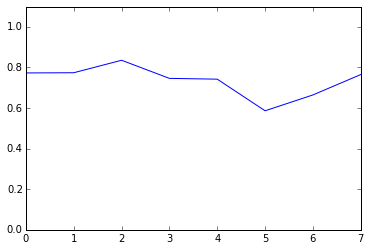

In [209]:
plt.plot(displacement)
plt.ylim(0, 1.1)

In [234]:
similarity = []
for model in models:
    try:
        similarity.append(model.similarity('embryo', 'egg'))
    except KeyError:
        pass

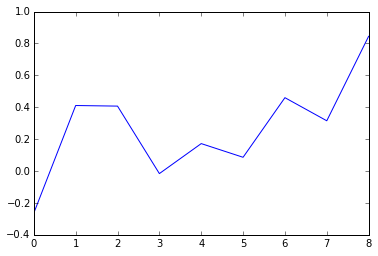

In [235]:
plt.plot(similarity)

In [87]:
models = []
model_corpora = []
for year, document_subset in documents_sorted:
#     vector_corpus = [dictionary.doc2bow(doc) for doc in document_subset]
#     tfidf_corpus = [tfidf[doc] for doc in vector_corpus]
    model = gensim.models.Word2Vec(document_subset, k)
#     lsa_corpus = lsa[tfidf_corpus]
    models.append(model)
#     model_corpora.append(lsa_corpus)
    print '\r', year,

2016


In [35]:
from scipy import stats
import numpy as np

In [211]:
models

In [120]:
transformations = []
for n, next_model in enumerate(models):
    if n+1 >= len(models):
        break
    shared_vocab = list(set(reference_model.vocab.keys()) & set(next_model.vocab.keys()))
    W = len(shared_vocab)
    sampled_words = list(set([shared_vocab[i] for i in np.random.randint(0, W, min(W, m))]))
    
    samples = reference_model.syn0[[reference_model.vocab[s].index for s in sampled_words], :]

    coefficient = np.zeros((k, k))
    intercept = np.zeros((k, k))
    for i in xrange(k):
        response_samples = next_model.syn0[[next_model.vocab[s].index for s in sampled_words], i]
        linearModel = LinearRegression(fit_intercept=False)
        linearModel.fit(samples, response_samples)
        coefficient[i, :] = linearModel.coef_ 
        intercept[i, :] = linearModel.intercept_
        
    transformations.append((coefficient, intercept))
    print '\r', n,

8


In [115]:
linearModel = LinearRegression()
linearModel.fit(samples, response_samples)

LinearRegression(copy_X=True, fit_intercept=True, normalize=False)

In [118]:
linearModel.intercept_

0.0055983161829787839

In [98]:
model.syn0.sum(axis=1).shape

(133,)

In [129]:
displacement = []
for n, transformation in enumerate(transformations):
    coefficient, intercept = transformation
    next_model = models[n+1]
    
    try:
        idx = reference_model.vocab['ivf'].index
        next_idx = next_model.vocab['ivf'].index
    except KeyError:
        displacement.append(0.)
        continue
    
    vect = reference_model.syn0[idx, :]
    next_vect = next_model.syn0[next_idx, :]
    
    proj_vect = np.zeros(k)
    for i in xrange(k):
        proj_vect[i] = (coefficient[i, :] * vect[i] + intercept[i, :]).sum()

    d = distance.cosine(proj_vect, next_vect)
    if np.isnan(d):    # Not in one of the models.
        d = 0.0
    displacement.append(d)

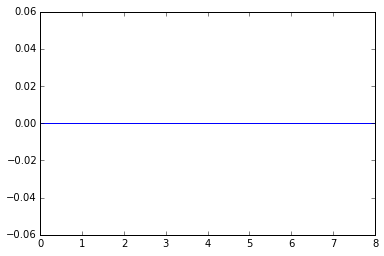

In [130]:
plt.plot(displacement)

In [110]:
models[0].similarity('embryo', 'egg'), models[1].similarity('embryo', 'egg'), models[2].similarity('embryo', 'egg')

(-0.26332006425929821, 0.41092636001220328, 0.40719795264322201)

In [79]:
dvec = lsa.projection.u * lsa.projection.s

0.0

280